In [1]:
import sframe as sf
import pandas as pd
import pydotplus
from IPython.display import Image, display  
import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics

[INFO] sframe.cython.cy_server: SFrame v2.0.1 started. Logging /tmp/sframe_server_1472313101.log
INFO:sframe.cython.cy_server:SFrame v2.0.1 started. Logging /tmp/sframe_server_1472313101.log


In [27]:
loans = sf.SFrame('lending-club-data.gl/')

In [3]:
loans.print_rows(num_columns = 68)

+---------+-----------+-----------+-------------+-----------------+------------+
|    id   | member_id | loan_amnt | funded_amnt | funded_amnt_inv |    term    |
+---------+-----------+-----------+-------------+-----------------+------------+
| 1077501 |  1296599  |    5000   |     5000    |       4975      |  36 months |
| 1077430 |  1314167  |    2500   |     2500    |       2500      |  60 months |
| 1077175 |  1313524  |    2400   |     2400    |       2400      |  36 months |
| 1076863 |  1277178  |   10000   |    10000    |      10000      |  36 months |
| 1075269 |  1311441  |    5000   |     5000    |       5000      |  36 months |
| 1072053 |  1288686  |    3000   |     3000    |       3000      |  36 months |
| 1071795 |  1306957  |    5600   |     5600    |       5600      |  60 months |
| 1071570 |  1306721  |    5375   |     5375    |       5350      |  60 months |
| 1070078 |  1305201  |    6500   |     6500    |       6500      |  60 months |
| 1069908 |  1305008  |   12

### Extracting the target and the feature columns
We are going to do some feature engineering on some of the feature variables.  In the dataset, some of the feature variables are categorical. Since we are building a binary decision tree, we will have to convert this to binary data in a subsequent section using 1-hot encoding.  

The column bad_loans will be our target - it shows whether the loan was paid or had to be written off.  We will re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, Our three categorical features will be:

1. is income verified
2. the length of the loan term
3. the home ownership status: own, mortgage, rent

The other features we will pick are:
1. loan amount
2. annual income
3. open accounts
4. employment length
5. grade number - grade number and sub_grade number define the interest rates
6. sub_grade number
7. short employment

In [28]:
cat_features = ['is_inc_v',           # Is income verified
                'term',               # the term of the loan
                'home_ownership',     # home ownership status: own, mortgage or rent
               ]
numer_features = ['loan_amnt',        # Loan amount
                  'annual_inc',       # Annual income
                  'emp_length_num',   # length of employment
                  'grade_num',        # Grade number
                  'sub_grade_num',     # Sub Grade number 
                  #'short_emp'         # Short employment  
                 ]

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
#loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[cat_features + numer_features + [target]]

In [29]:
loans

is_inc_v,term,home_ownership,loan_amnt,annual_inc,emp_length_num,grade_num,sub_grade_num
Verified,36 months,RENT,5000,24000,11,5,0.4
Source Verified,60 months,RENT,2500,30000,1,4,0.8
Not Verified,36 months,RENT,2400,12252,11,4,1.0
Source Verified,36 months,RENT,10000,49200,11,4,0.2
Source Verified,36 months,RENT,5000,36000,4,6,0.8
Source Verified,36 months,RENT,3000,48000,10,2,0.2
Source Verified,60 months,OWN,5600,40000,5,1,0.4
Verified,60 months,RENT,5375,15000,1,5,1.0
Not Verified,60 months,OWN,6500,72000,6,4,0.6
Source Verified,36 months,OWN,12000,75000,11,5,1.0


Subsample dataset to make sure classes are balanced

We will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points.


In [30]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


Note: There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this work, but some of them are reviewed in this paper. We have used the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

Transform categorical data into binary features

Some of the features are currently categorical features, we want to turn them into binary features using 1-hot encoding.

We can do so with the following code block (see the first assignments for more details):


In [31]:
loans_data = risky_loans.append(safe_loans)
for feature in cat_features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

Let's see what the feature columns look like now:

In [32]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features

['loan_amnt',
 'annual_inc',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'is_inc_v.Not Verified',
 'is_inc_v.Source Verified',
 'is_inc_v.Verified',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT']

Train-test split

We split the data into training and test sets with 80% of the data in the training set and 20% of the data in the test set. 


In [33]:
train_data, test_data = loans_data.random_split(0.8, seed=1)

In [34]:
def get_numpy_data(data_sframe, features, output):
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe 
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [35]:
(train_feature_matrix, train_output) = get_numpy_data(train_data,features, target)
(test_feature_matrix, test_output) = get_numpy_data(test_data, features, target)
#(normalized_all_feature_matrix, all_norms) = normalize_features(all_feature_matrix) # normalize features

In [36]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=20, random_state=99)
clf = clf.fit(train_feature_matrix, train_output)
print "Score for test data " + str(clf.score(test_feature_matrix,test_output))
print "Score for train data " + str(clf.score(train_feature_matrix, train_output))

Score for test data 0.619668246445
Score for train data 0.664651837524


In [37]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.
    
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    dot_data = StringIO.StringIO()  
    export_graphviz(tree, out_file=dot_data,  
                             feature_names=feature_names, max_depth = 5,  
                             filled=True, rounded=True,rotate=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(r"test1.png")
    return Image(graph.create_png())  

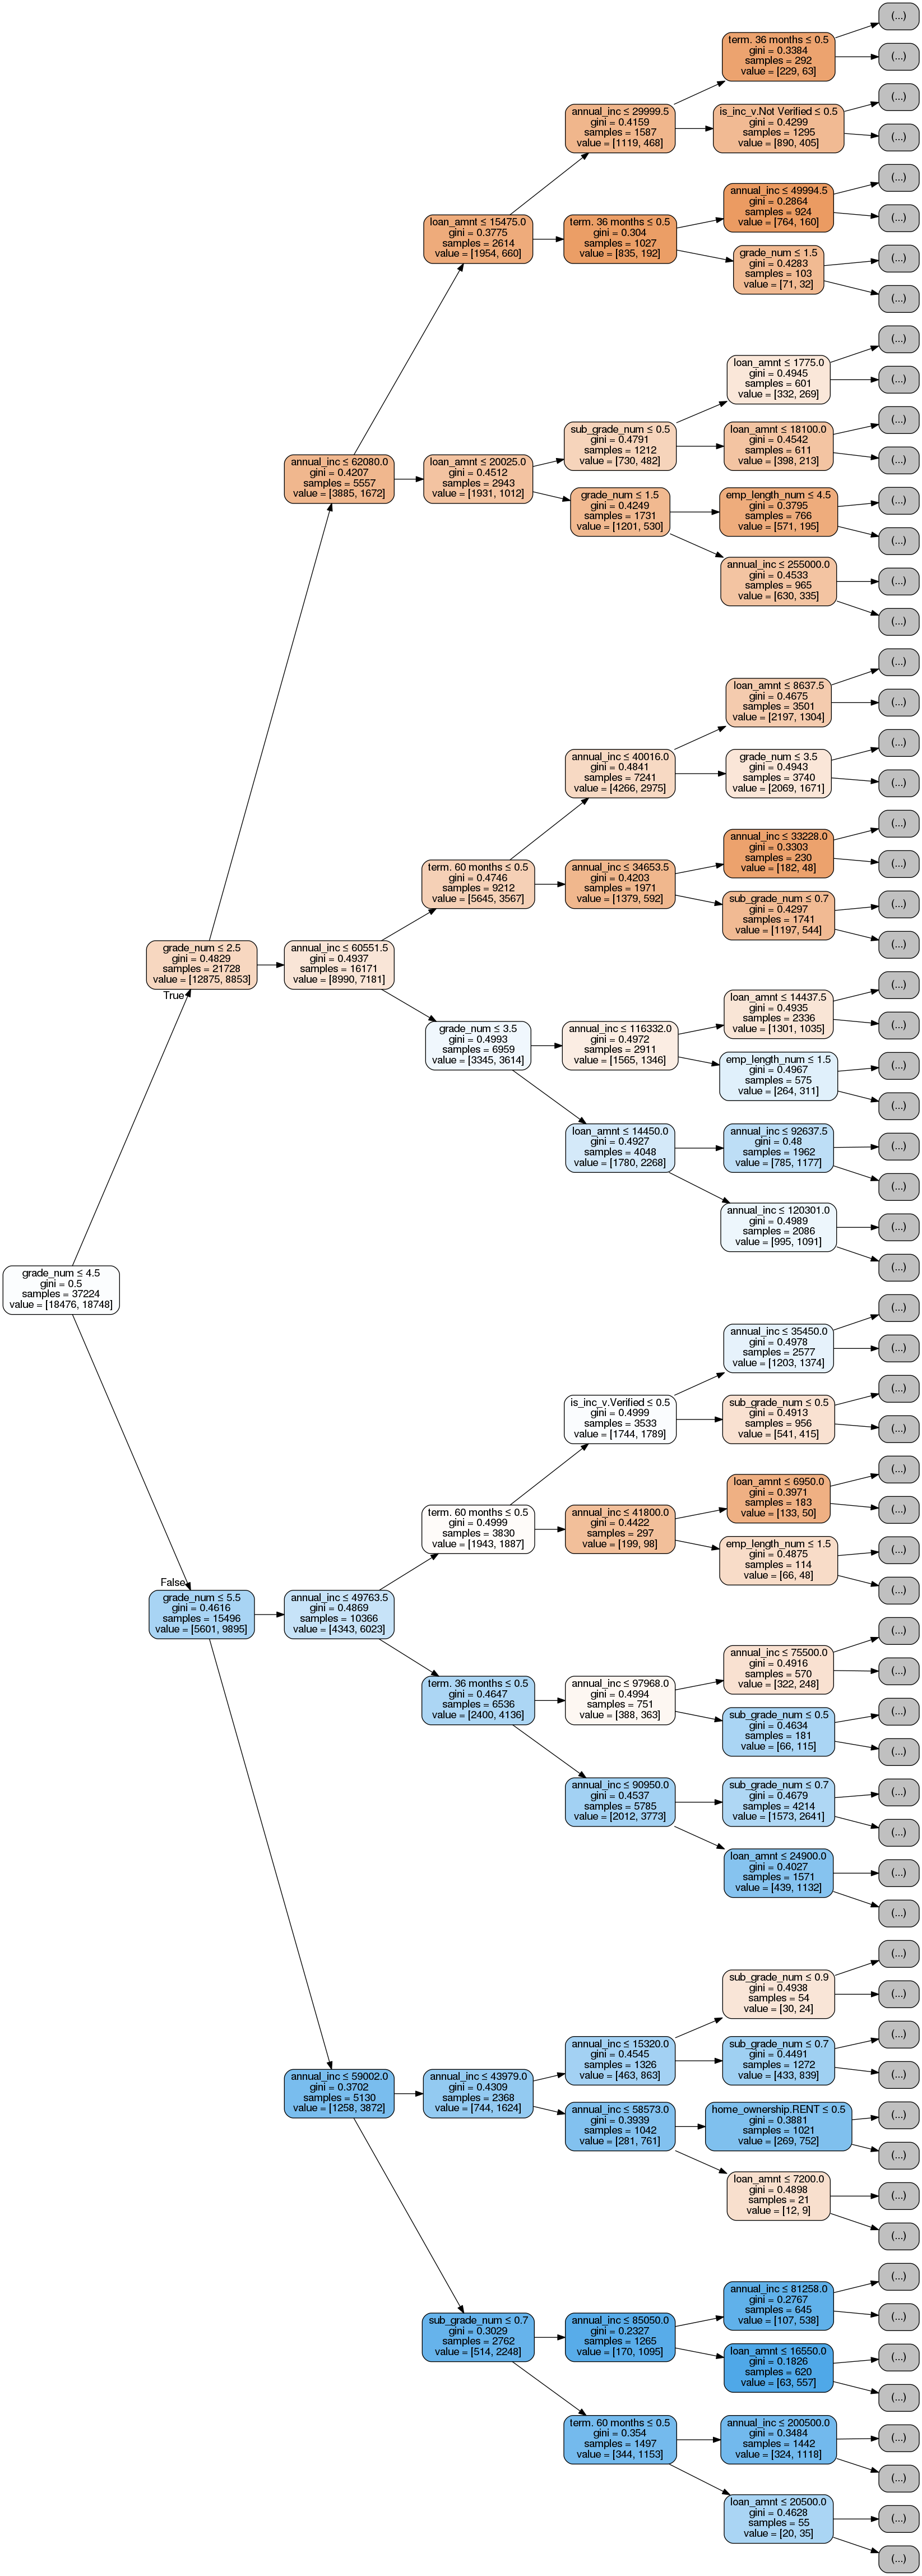

In [38]:
display(visualize_tree(clf, features))

In [39]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(train_feature_matrix, train_output)
print "Score for test data " + str(bdt.score(test_feature_matrix,test_output))
print "Score for train data " + str(bdt.score(train_feature_matrix, train_output))

Score for test data 0.637979319259
Score for train data 0.636793466581


In [40]:
# Create and fit an AdaBoosted decision tree based on RandomTree
bdt2 = AdaBoostClassifier(base_estimator = RandomForestClassifier(n_estimators = 20, criterion = 'entropy'), 
                         algorithm = 'SAMME.R')

bdt2.fit(train_feature_matrix, train_output)
print "Score for test data " + str(bdt2.score(test_feature_matrix,test_output))
print "Score for train data " + str(bdt2.score(train_feature_matrix, train_output))

Score for test data 0.589939681172
Score for train data 0.997447883086


In [41]:
# Create Random Forest object
rdt= RandomForestClassifier(n_estimators=1000)
# Train the model using the training sets and check score
rdt.fit(train_feature_matrix, train_output)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
rdt.score(test_feature_matrix,test_output)

0.60275743214131838

In [43]:
rdt.score(train_feature_matrix,train_output)

0.99744788308618093

In [44]:
predictions = bdt.predict(test_feature_matrix)
cm = confusion_matrix(test_output, predictions)
print(cm)

[[3042 1632]
 [1729 2881]]


In [45]:
# Generate table of actual vs prediction confusion matrix
bdt_confusion = pd.crosstab(test_output, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
bdt_conf_norm = bdt_confusion / bdt_confusion.sum(axis=1)
bdt_confusion

Predicted,-1,1,All
Actual,,,
-1,3042,1632,4674
1,1729,2881,4610
All,4771,4513,9284


In [46]:
bdt_conf_norm

Predicted,-1,1,All
Actual,,,
-1,0.325417,0.177007,0.251723
1,0.184959,0.312473,0.248277
All,0.510377,0.489479,0.500000


In [47]:
# View summary of common classification metrics
print(metrics.classification_report(y_true=test_output,y_pred=predictions))

             precision    recall  f1-score   support

         -1       0.64      0.65      0.64      4674
          1       0.64      0.62      0.63      4610

avg / total       0.64      0.64      0.64      9284



Decision Tree algorithms are very prone to over fitting.

In [48]:
lendingclub_data_pandas = loans.to_dataframe()
print(lendingclub_data_pandas.describe())
lendingclub_data_pandas.hist();

           loan_amnt    annual_inc  emp_length_num      grade_num  \
count  122607.000000  1.226030e+05   122607.000000  122607.000000   
mean    12809.733743  7.138502e+04        6.370256       4.232882   
std      7932.313398  5.841483e+04        3.736014       1.362138   
min       500.000000  1.896000e+03        0.000000       0.000000   
25%      6700.000000           NaN        3.000000       3.000000   
50%     11000.000000           NaN        6.000000       4.000000   
75%     17600.000000           NaN       11.000000       5.000000   
max     35000.000000  7.141778e+06       11.000000       6.000000   

       sub_grade_num     safe_loans  
count  122607.000000  122607.000000  
mean        0.597509       0.622371  
std         0.278934       0.782726  
min         0.200000      -1.000000  
25%         0.400000       1.000000  
50%         0.600000       1.000000  
75%         0.800000       1.000000  
max         1.000000       1.000000  
